#Khai báo thư viện

In [1]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import cv2 
from google.colab.patches import cv2_imshow

#Liên kết đường dẫn

In [2]:
drive.mount('/content/drive')
dir = '/content/drive/MyDrive'
dir_img = os.path.join(dir,"Đồ án CV", "Image")

Mounted at /content/drive


##Lấy ảnh



In [3]:
path_files = []
files = ['skiing','apple','therock','cat']
for name in files:
      path_files.append(dir_img + '/choose/'+ name + '.jpg')

In [4]:
print(files)

['skiing', 'apple', 'therock', 'cat']


###Ground truth

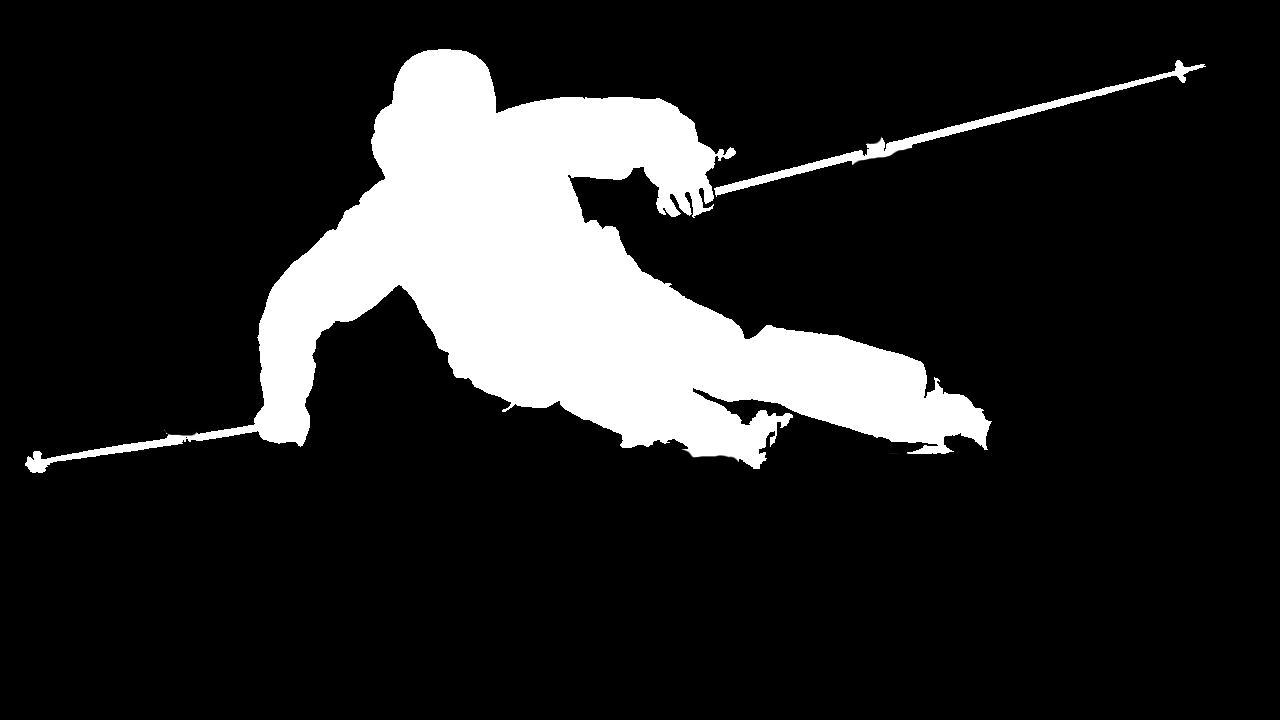

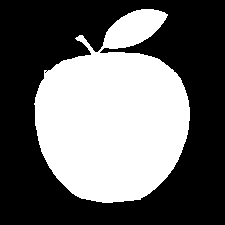

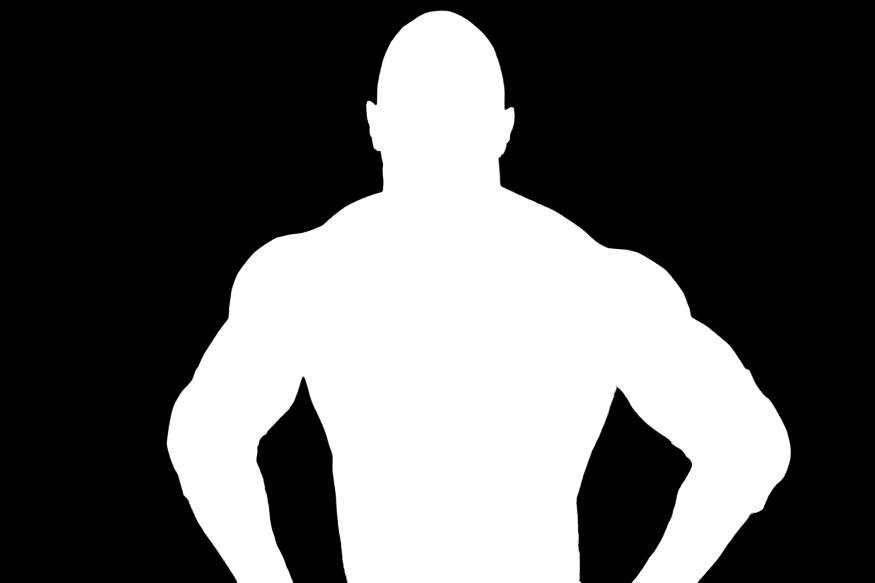

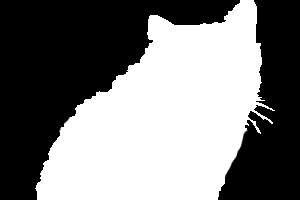

In [5]:
path_gt = []
for name in files:
      path_gt.append(dir_img+'/Ground truth' + '/'+ name + '_GT.jpg')
      cv2_imshow(cv2.imread(path_gt[-1]))

#Edge Based Segmentation 

In [6]:
def sobel_edge_detection(image,filename, blur_ksize=7, sobel_ksize=1, skipping_threshold=30):
    """
    image_path: link to image
    blur_ksize: kernel size parameter for Gaussian Blurry
    sobel_ksize: size of the extended Sobel kernel; it must be 1, 3, 5, or 7.
    skipping_threshold: ignore weakly edge
    """
    
    # convert BGR to gray
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    path = '/content/drive/MyDrive/Đồ án CV/Image/Output/EBS'
    #
    if filename == 'skiing':
      skipping_threshold = 10
      img_gaussian = cv2.GaussianBlur(gray,(blur_ksize,blur_ksize),0)
    elif filename == 'apple':
      skipping_threshold = 10
      img_gaussian = cv2.GaussianBlur(gray,(blur_ksize,blur_ksize),0)
    elif filename == 'cat': 
      skipping_threshold = 4
      img_gaussian = cv2.GaussianBlur(gray, (1, 1), 0)
    elif filename == 'therock':
      skipping_threshold=1
      img_gaussian = cv2.GaussianBlur(gray,(7,7),0)
    else: 
      skipping_threshold = 20
      img_gaussian = cv2.GaussianBlur(gray,(3,3),0)
    cv2.imwrite(os.path.join(path , filename+'_blur.jpg'), img_gaussian)
    # cv2_imshow(img_gaussian)

    # sobel algorthm use cv2.CV_64F
    sobelx64f = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=sobel_ksize)
    abs_sobel64f = np.absolute(sobelx64f)
    img_sobelx = np.uint8(abs_sobel64f)

    sobely64f = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
    abs_sobel64f = np.absolute(sobely64f)
    img_sobely = np.uint8(abs_sobel64f)
    
    
    # calculate magnitude
    img_sobel = (img_sobelx + img_sobely)/2
    cv2_imshow(img_sobel)
    
    cv2.imwrite(os.path.join(path , filename+'_edge.jpg'), img_sobel)
    # ignore weakly pixel
    for i in range(img_sobel.shape[0]):
        for j in range(img_sobel.shape[1]):
            if img_sobel[i][j] < skipping_threshold:
                img_sobel[i][j] = 0
            else:
                img_sobel[i][j] = 255
    cv2_imshow(img_sobel)
    cv2.imwrite(os.path.join(path , filename+'_binary.jpg'), img_sobel)
    return img_sobel


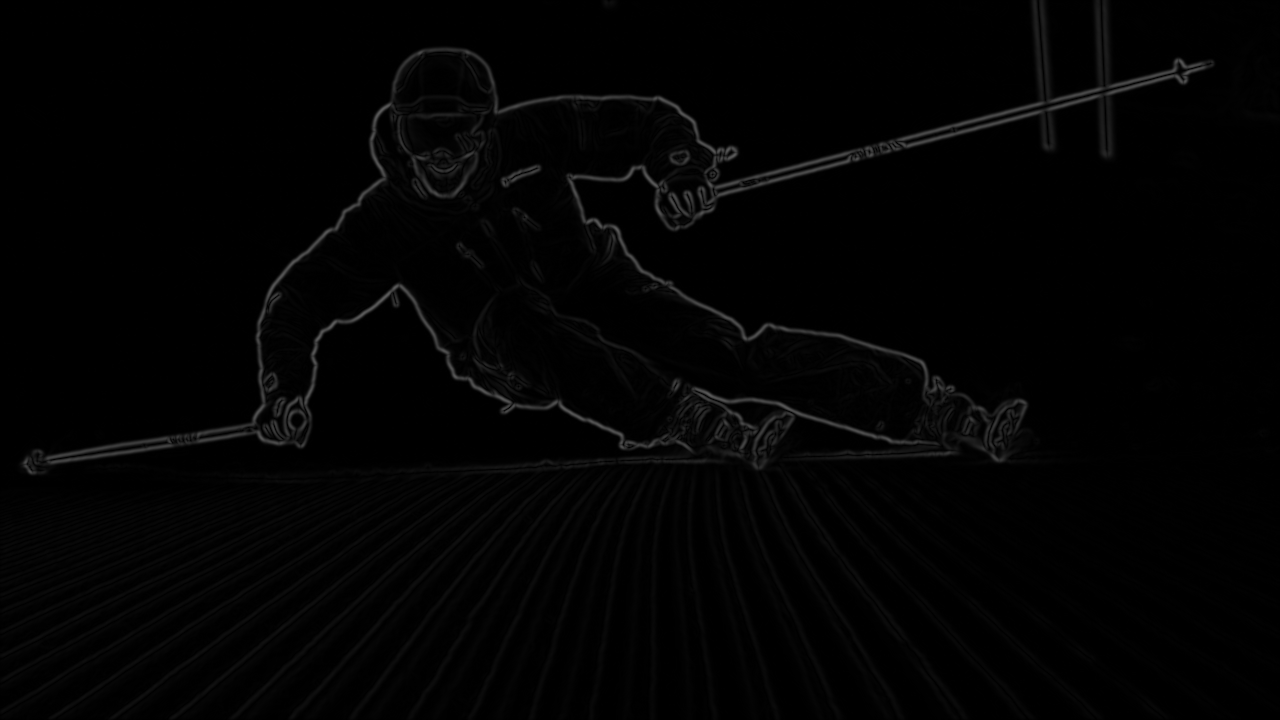

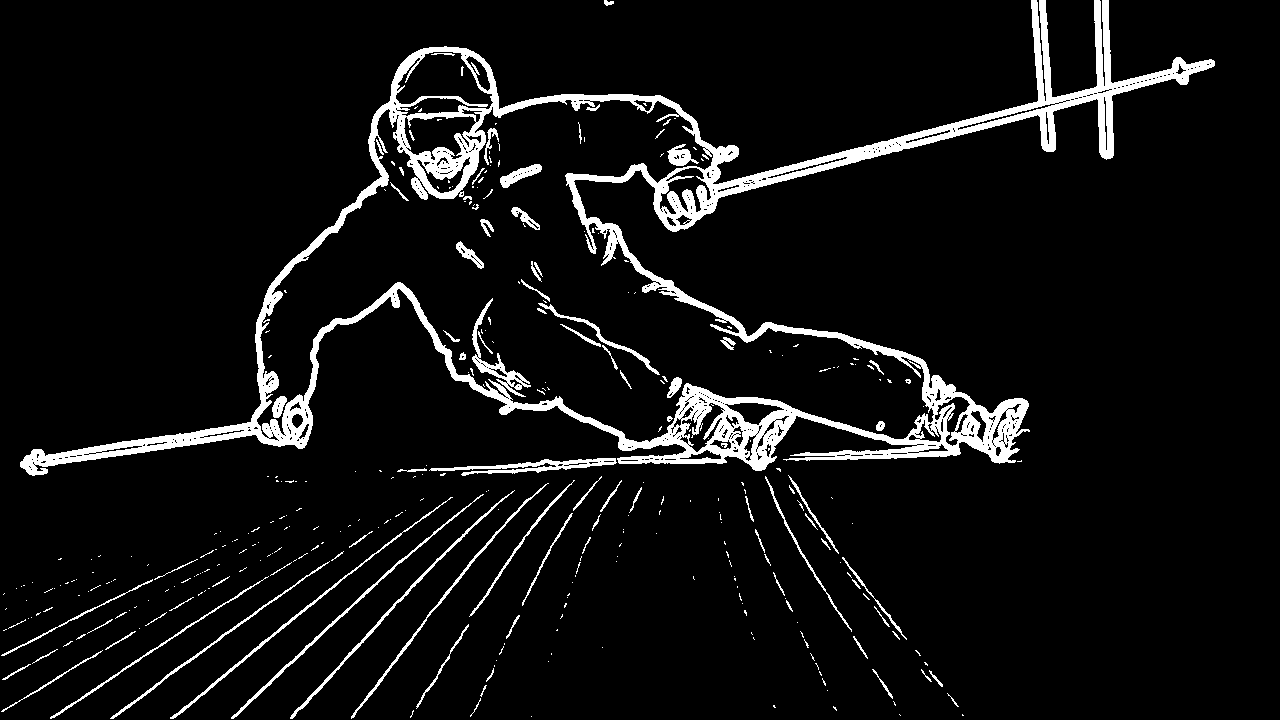

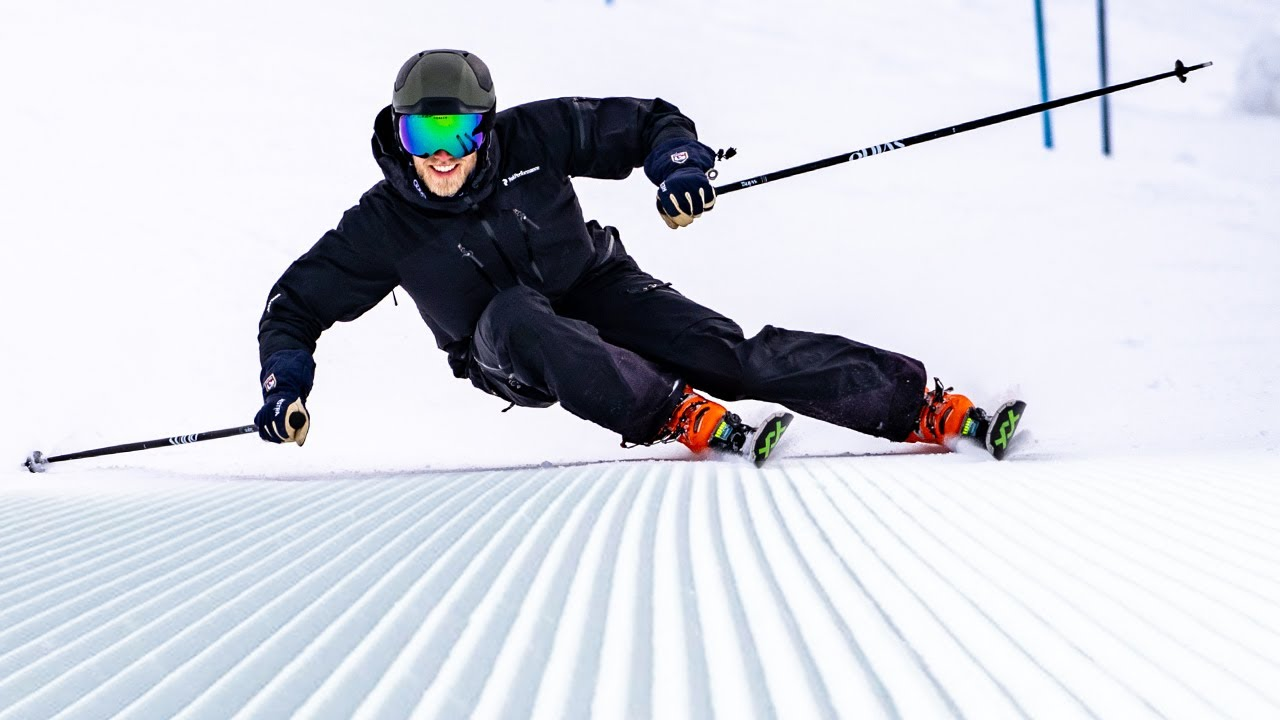

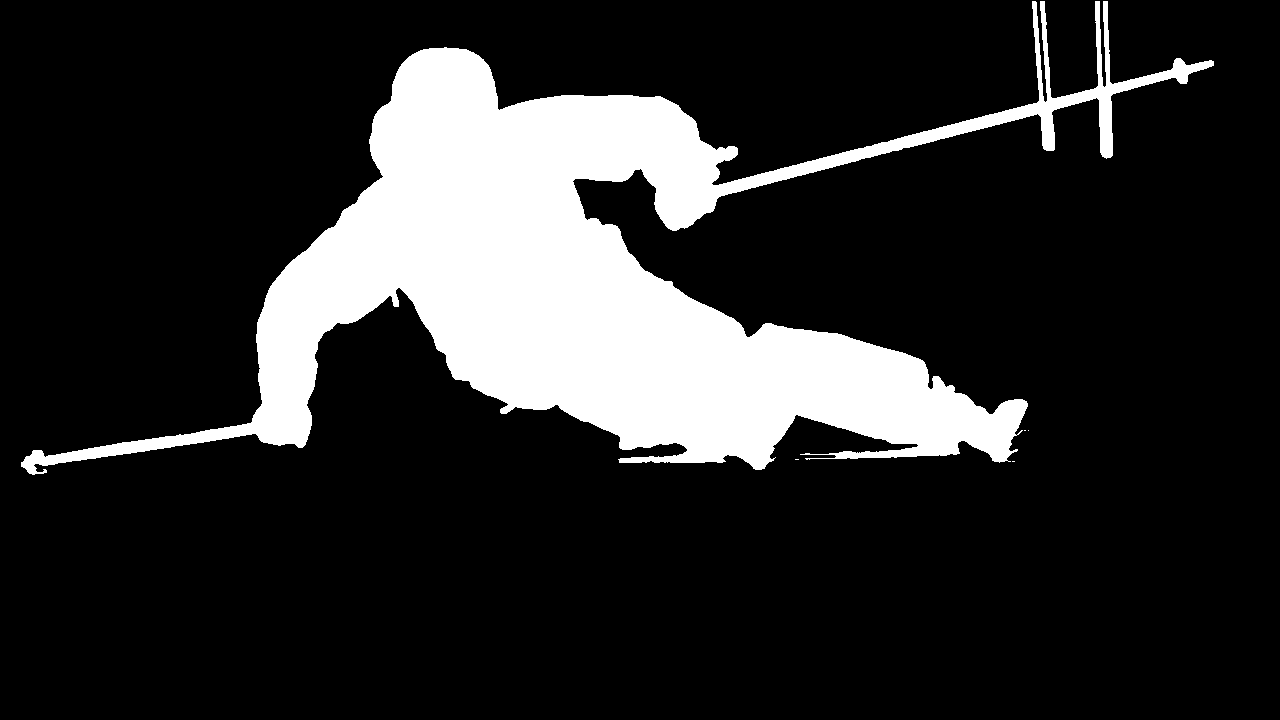

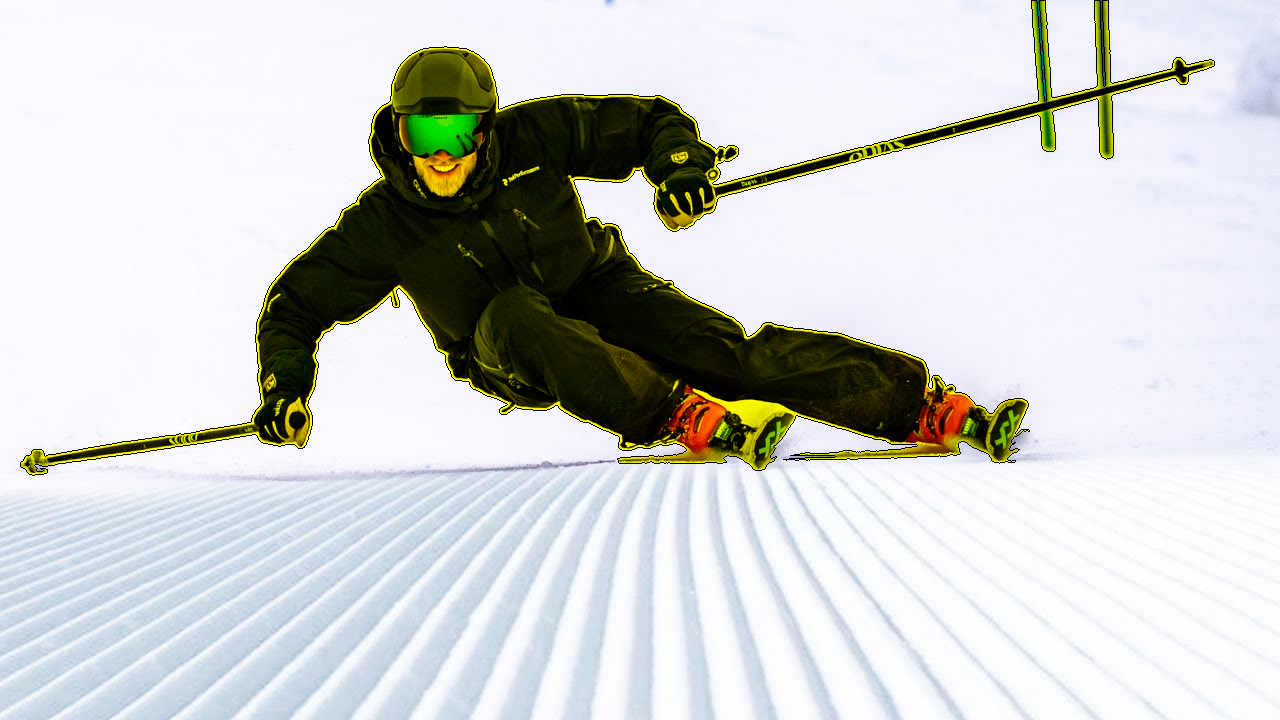

In [7]:
def EBS2(path,filename):
  # read image
  image = cv2.imread(path)
  sobel = sobel_edge_detection(image,filename)
  sobel = np.array(sobel,dtype=np.uint8)
  

  # create canvas
  canvas = np.zeros(image.shape, np.uint8)
  canvas.fill(255)

  # create background mask
  mask = np.zeros(image.shape, np.uint8)
  # mask.fill(255)

  # get contours
  # contours_draw, hierachy = cv2.findContours(sobel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  contours_draw, hierachy = cv2.findContours(sobel,  cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  
  # draw all contours
  # cv2.drawContours(mask, contours_draw, 1, (255,255,255), 3)
  max_area = 0
  best_cnt = None
  mask = np.zeros((image.shape), np.uint8)
  
  for counter in contours_draw:
      area = cv2.contourArea(counter)
      if area > 10:
          if area > max_area:
              max_area = area
              best_cnt = counter
                
  cv2.drawContours(canvas, [best_cnt], 0,(0,255,255), -1)
  cv2.drawContours(canvas, [best_cnt], 0, 0, 0)
  cv2.drawContours(mask, [best_cnt], 0, (255,255,255), -1)
  cv2.drawContours(mask, [best_cnt], 0, 0, 0)

 
  # display the image in a window
  # cv2_imshow(sobel)
  cv2_imshow(image)
  # cv2_imshow( canvas)
  cv2_imshow(mask)
  # cv2_imshow(mask_color)
  cv2_imshow( cv2.bitwise_and(image, canvas))

  # write images
  path = '/content/drive/MyDrive/Đồ án CV/Image/Output/EBS'
  # cv2.imwrite(os.path.join(path , filename+'_edge.jpg'), sobel)
  cv2.imwrite(os.path.join(path , filename+'_mask.jpg'), mask)
  cv2.imwrite(os.path.join(path , filename+'_cover.jpg'), cv2.bitwise_and(image, canvas))

index = files.index('skiing')
EBS2(path_files[index],files[index])

In [8]:
for i in range(len(path_files)):
  EBS2(path_files[i],files[i])

Output hidden; open in https://colab.research.google.com to view.

#IOU

In [9]:
def show2image(img1,img2,name,iou=0):
  _, axs = plt.subplots(1, 2, figsize=(12, 12))
  # plt.title(f'iou = {iou}')
  axs[0].imshow(img1)
  axs[0].title.set_text(name + ' mask')
  axs[1].imshow(img2)
  axs[1].title.set_text(name + ' ground truth')
  plt.show()

In [10]:
def CountIOU(img1, img2):
  intersection = np.logical_and(img1, img2)
  union = np.logical_or(img1, img2)
  iou_score = np.sum(intersection) / np.sum(union)
  return iou_score

In [11]:
path_o = []
for name in files:
      path_o.append(dir_img+'/Output/EBS' + '/'+ name + '_mask.jpg')
      # cv2_imshow(cv2.imread(path_o[-1]))
    

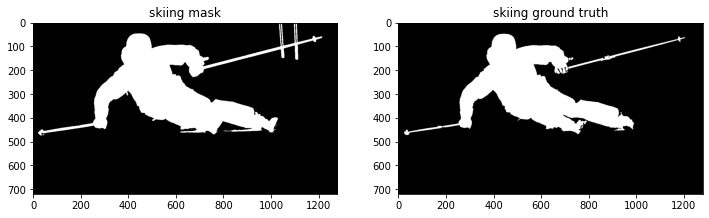

0.8473205568280207


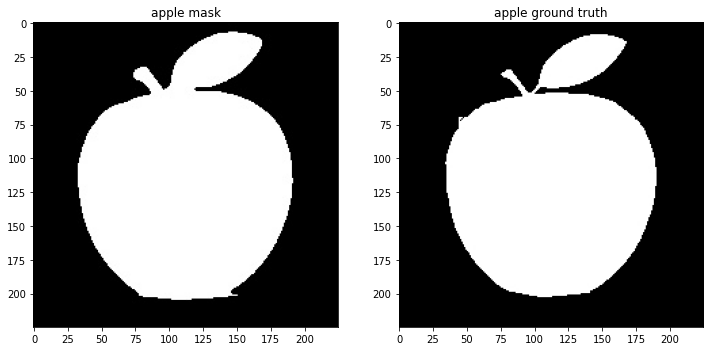

0.8982430453879942


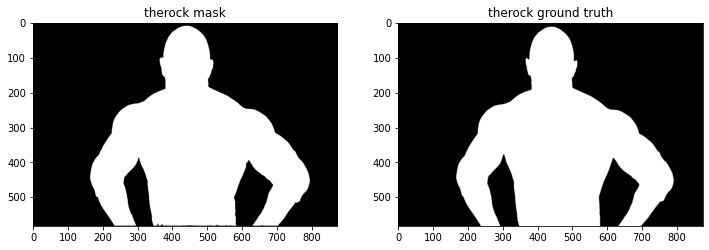

0.9544062074872777


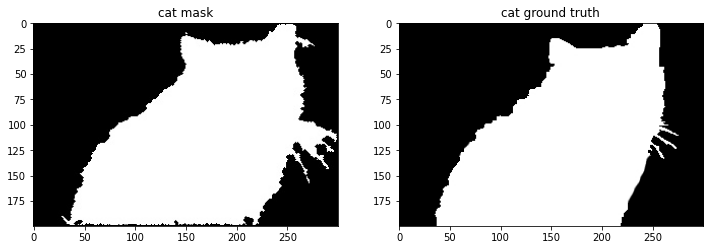

0.8827424177701837


In [12]:
for i in range(len(files)):
  predict = cv2.imread(path_o[i])
  gt = cv2.imread(path_gt[i])
  show2image(predict,gt,files[i])
  print(CountIOU(predict,gt))

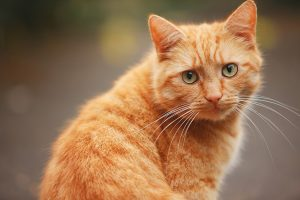

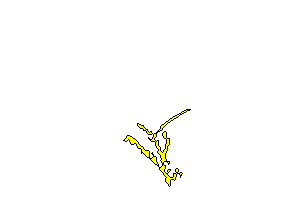

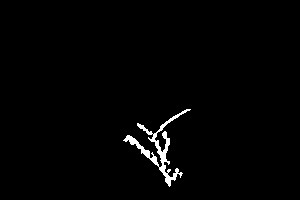

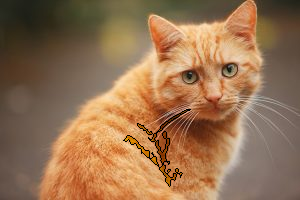

In [13]:
def EBS(path):
  image = cv2.imread(path, )

  # convert image to grayscale
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(image_gray,(5,5),0)
  # blur = cv2.GaussianBlur(image_gray,(5,5),cv2.BORDER_DEFAULT)
  # blur = cv2.GaussianBlur(image_gray,(10,10),cv2.BORDER_DEFAULT)
  # blur = cv2.GaussianBlur(image_gray,(5,5),cv2.BORDER_TRANSPARENT)
  # onvert image to blck and white
  # edges = cv2.Canny(image=blur, threshold1=1, threshold2=200)
  # thresh= cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY)
  thresh = cv2.adaptiveThreshold(blur, 
                                       maxValue=255, 
                                       adaptiveMethod=1, 
                                       thresholdType=1,
                                       blockSize=11,
                                       C=2)
  # thresh = cv2.adaptiveThreshold(blur, 100 , 1, 1, 11,2)
  # thresh = cv2.adaptiveThreshold(sobel, 100 , 1, 1, 11,2)
  # cv2_imshow(thresh)
  # print(thresh)
  
  # cv2_imshow(image_edges)
  # create canvas
  canvas = np.zeros(image.shape, np.uint8)
  canvas.fill(255)

  # create background mask
  mask = np.zeros(image.shape, np.uint8)
  # mask.fill(255)

  # create new background
  new_background = np.zeros(image.shape, np.uint8)
  new_background.fill(255)

  # get all contours
  # contours_draw, hierachy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

  # get most significant contours
  contours_draw, hierachy = cv2.findContours(thresh,  cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  # contours_draw, hierachy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  # contours_draw, hierachy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  # contours_draw, hierachy = cv2.findContours(sobel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  # contours_draw, hierachy=cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  # draw all contours
  #cv2.drawContours(canvas, contours_draw, 1, (0, 0, 0), 3)
  max_area = 0
  best_cnt = None
  mask = np.zeros((image.shape), np.uint8)
  
  for counter in contours_draw:
      area = cv2.contourArea(counter)
      if area > 1:
          if area > max_area:
              max_area = area
              best_cnt = counter
                
  cv2.drawContours(canvas, [best_cnt], 0,(0,255,255), -1)
  cv2.drawContours(canvas, [best_cnt], 0, 0, 0)
  cv2.drawContours(mask, [best_cnt], 0, (255,255,255), -1)
  cv2.drawContours(mask, [best_cnt], 0, (255,255,255), 0)
  # display the image in a window
  cv2_imshow(image)
  cv2_imshow( canvas)
  cv2_imshow(mask)
  # cv2_imshow( new_background)
  cv2_imshow( cv2.bitwise_and(image, canvas))

  # write images
  # cv2.imwrite('contours.png', canvas)
  # cv2.imwrite('mask.png', mask)
  # cv2.imwrite('background.png', new_background)
  # cv2.imwrite('output.png', cv2.bitwise_and(image, new_background))
EBS(path_files[-1])